In [ ]:
import warnings

def warn(*args, **kwargs):
    pass

warnings.warn = warn

In [ ]:
import time
import numpy as np
import pandas as pd
import re

import keras
from keras import *
from keras import layers
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.models import Model
from keras.preprocessing import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from numpy.random import seed
seed(302)


In [ ]:

train_df = pd.read_csv('train_df.csv')
valid_df = pd.read_csv('validate_df.csv')
test_df = pd.read_csv('test_df.csv')

full_dataset_df =  pd.read_csv('full_tweets_df.csv')

X_train = train_df['tweet_text']
Y_train = train_df['text_info']

X_valid = valid_df['tweet_text']
Y_valid = valid_df['text_info']

X_test = test_df['tweet_text']
Y_test = test_df['text_info']


In [ ]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)

# train data
tok.fit_on_texts(X_train)
train_sequences = tok.texts_to_sequences(X_train)
train_sequences_matrix = sequence.pad_sequences(train_sequences,maxlen=max_len)

# validate data
valid_sequences = tok.texts_to_sequences(X_valid)
valid_sequences_matrix = sequence.pad_sequences(valid_sequences,maxlen=max_len)

# test_data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.3f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def plot_summaries(data1, data2, title, ylabel,fname):
    plt.plot(data1)
    plt.plot(data2)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig(fname+".png")

In [ ]:
FILTERS_SIZE = 16
KERNEL_SIZE = 5

# Define embeddings dimensions (columns in matrix fed into CNN and nodes in hidden layer of built-in keras function)
EMBEDDINGS_DIM = 10

# Hyperparameters for model tuning
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 7

In [ ]:
model = Sequential()
VOCABULARY_SIZE = 5000
# We use built-in keras funtion to generate embeddings. Another option is pre-trained embeddings with Word2vec or GloVe.
model.add(Embedding(input_dim=VOCABULARY_SIZE + 1, output_dim=EMBEDDINGS_DIM, input_length=len(train_sequences_matrix[0])))
model.add(Conv1D(FILTERS_SIZE, KERNEL_SIZE, activation='relu'))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
            
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 10)           50010     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 146, 16)           816       
_________________________________________________________________
dropout_2 (Dropout)          (None, 146, 16)           0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
history = model.fit(train_sequences_matrix, Y_train, validation_data = (valid_sequences_matrix, Y_valid), batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/7
280/280 [==============================] - 1s 5ms/step - loss: 0.6050 - accuracy: 0.6629 - val_loss: 0.5425 - val_accuracy: 0.6646
Epoch 2/7
280/280 [==============================] - 1s 5ms/step - loss: 0.4883 - accuracy: 0.7884 - val_loss: 0.4693 - val_accuracy: 0.8213
Epoch 3/7
280/280 [==============================] - 1s 5ms/step - loss: 0.4271 - accuracy: 0.8225 - val_loss: 0.4378 - val_accuracy: 0.8135
Epoch 4/7
280/280 [==============================] - 1s 5ms/step - loss: 0.3891 - accuracy: 0.8385 - val_loss: 0.4369 - val_accuracy: 0.8020
Epoch 5/7
280/280 [==============================] - 1s 5ms/step - loss: 0.3704 - accuracy: 0.8439 - val_loss: 0.4252 - val_accuracy: 0.8145
Epoch 6/7
280/280 [==============================] - 1s 5ms/step - loss: 0.3522 - accuracy: 0.8574 - val_loss: 0.4239 - val_accuracy: 0.8156
Epoch 7/7
280/280 [==============================] - 1s 5ms/step - loss: 0.3392 - accuracy: 0.8629 - val_loss: 0.4205 - val_accuracy: 0.8166


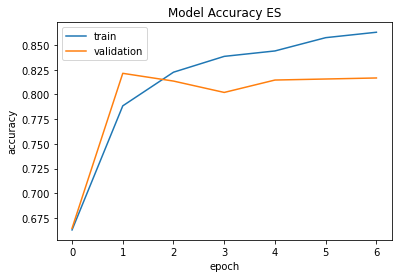

In [ ]:
plot_summaries(history.history['accuracy'],history.history['val_accuracy'],\
              "Model Accuracy ES", "accuracy", "acc_ES")

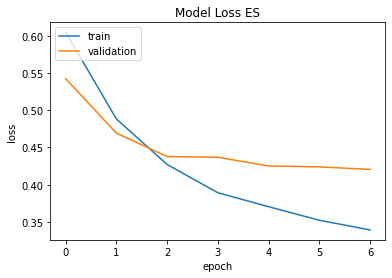

In [ ]:
plot_summaries(history.history['loss'],history.history['val_loss'],\
              "Model Loss ES", "loss","loss_ES")

In [ ]:
predictions_df = pd.DataFrame(model.predict(test_sequences_matrix))
predictions_binary_df = round(predictions_df)
accuracy_score(Y_test, predictions_binary_df)

0.8339425587467363

In [ ]:
model.save('CNN')


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: CNN/assets


In [ ]:

from tensorflow import keras
model = keras.models.load_model('CNN')

In [ ]:
history1 = model.fit(train_sequences_matrix, Y_train, validation_data = (test_sequences_matrix, Y_test), batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/7
280/280 [==============================] - 1s 5ms/step - loss: 0.3228 - accuracy: 0.8681 - val_loss: 0.3776 - val_accuracy: 0.8355
Epoch 2/7
280/280 [==============================] - 1s 5ms/step - loss: 0.3166 - accuracy: 0.8700 - val_loss: 0.3866 - val_accuracy: 0.8292
Epoch 3/7
280/280 [==============================] - 1s 5ms/step - loss: 0.3014 - accuracy: 0.8762 - val_loss: 0.3816 - val_accuracy: 0.8366
Epoch 4/7
280/280 [==============================] - 1s 4ms/step - loss: 0.2897 - accuracy: 0.8837 - val_loss: 0.3855 - val_accuracy: 0.8287
Epoch 5/7
280/280 [==============================] - 1s 5ms/step - loss: 0.2781 - accuracy: 0.8911 - val_loss: 0.3964 - val_accuracy: 0.8219
Epoch 6/7
280/280 [==============================] - 1s 5ms/step - loss: 0.2718 - accuracy: 0.8944 - val_loss: 0.4023 - val_accuracy: 0.8230
Epoch 7/7
280/280 [==============================] - 1s 5ms/step - loss: 0.2633 - accuracy: 0.8981 - val_loss: 0.4094 - val_accuracy: 0.8188


In [ ]:
predictions_df1 = pd.DataFrame(model.predict(test_sequences_matrix))
predictions_binary_df1 = round(predictions_df1)
accuracy_score(Y_test, predictions_binary_df1)

0.8187989556135771

In [ ]:
X_train_f = pd.concat([train_df,valid_df])
X_train_f["predictions"] =predictions_binary_df1
X_train_f.to_csv("predictions_full_train_df.csv")

In [ ]:
test_df["predictions"] = predictions_binary_df
test_df.to_csv("predictions_test_df.csv")